# Mathematics for signal processing notebook
Guillaume TOCHON (<guillaume.tochon@lrde.epita.fr>) & Ã‰lodie PUYBAREAU (<elodie@lrde.epita.fr>)


Typical reaction of an average EPITA student when he discovered that this course was about the Fourier transform and that kind of stuff :

<img src="http://www.reactiongifs.com/r/oh-shi.gif" width="365"> | <img src="http://www.funnybeing.com/wp-content/uploads/2017/01/WTF-Is-This-Shit-600x378.jpg" width="435">
--- | ---
|

In [1]:
# Import all custom-made functions
import MASI
import ECG
# Import all the usual stuff
import numpy as np
pi = np.pi # coz' I'm lazy af
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
# Matplotlib in inline mode
%matplotlib inline
# Shut warnings off (I'm a terrible person)
import warnings
warnings.filterwarnings('ignore')


## Correlation versus convolution

### Correlation

In [2]:
# defining time vector
tmax = 15 # max time (in sec)
tmin = 0 # min time (does not mean anything but has to be defined)
fe = 250 # sampling frequency (in Hz)
Te = 1/fe # sampling period (fe points per second)
t = np.arange(tmin,tmax,Te)

Radar detection works by sending out in the air some reference electromagnetic signal. It then deduces the position of the object that reflected the emitted signal by measuring the time delay between the sent and the received waves.

In [3]:
# define reference gaussian modulated pulse wave
A_ref = 2
t0 = 1.2
f0 = 1
x_ref = A_ref*np.exp(-t/t0)*np.sin(2*pi*f0*t)

In [4]:
# Define received echo with random arrival time and magnitude
def simulateEcho(t,A=0,tau=0,sigma=0):
    if A == 0:
        A = np.random.triangular(0.5*A_ref,0.75*A_ref,A_ref)
    if tau == 0:
        tau=np.random.uniform(2,9)
    echo = A*np.exp(-(t-tau)/t0)*np.sin(2*pi*f0*(t-tau))*((t>tau)*1.0)+np.random.normal(scale=sigma,size=t.shape)
    return (echo,tau)

Ideally, what should be measured by the detector is simply a delayed version of the sent wave.  
Even in this simplistic and not realistic-at-all case, how can we measure the delay ?


In practice, the received signal :
- is of lower magnitude. Part of the sent energy has been lost in the wild
- has unknow delay. Would be a pice of cake if we knew in advance how far is the object to detect
- is corrupted by noise, introduced by the medium in which the wave is travelling (air, water, etc)

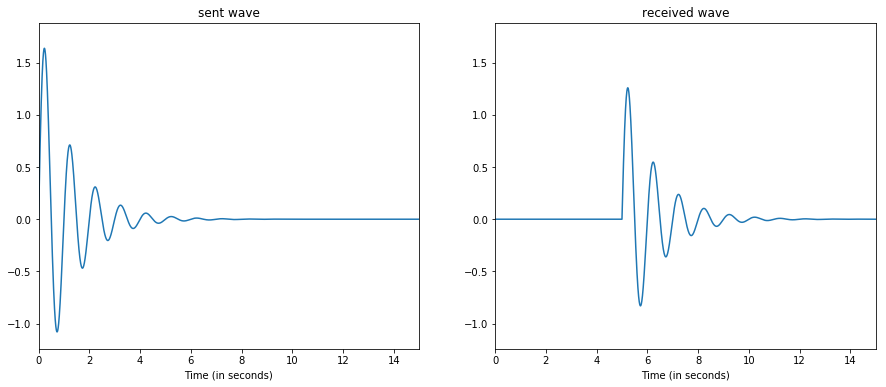

In [5]:
(y,delay_true) = simulateEcho(t,A=0,tau=5,sigma=0)
# ----------------------------------
# -------- plot that stuff ---------
# ----------------------------------
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(t,x_ref)
plt.xlim((t.min(),t.max()))
plt.xlabel('Time (in seconds)')
plt.ylim((1.15*x_ref.min(),1.15*x_ref.max()))
plt.title('sent wave')
plt.subplot(122)
plt.plot(t,y)
plt.xlim((t.min(),t.max()))
plt.xlabel('Time (in seconds)')
m = min(1.15*x_ref.min(),1.15*y.min())
M = max(1.15*x_ref.max(),1.15*y.max())
plt.ylim((m,M))
plt.title('received wave')
plt.show()

Let us define $$\Gamma_{x_{\text{ref}}y} (\tau) = \left\langle x_{\text{ref}}(t),y(t-\tau)\right\rangle = \int_\mathbb{R} x_{\text{ref}}(t) \overline{{y(t-\tau)}}dt$$ to be the **cross-correlation** between the reference wave $x_\text{ref}$ and the received one $y$.

Then, the unknown delay $\tau_\text{est}$ can be computed as $$ \tau_\text{est} = -\arg\max_{\tau \in \mathbb{R}} \Gamma_{x_{\text{ref}}y} (\tau) $$ where $\arg\max_{\tau \in \mathbb{R}} \Gamma_{x_{\text{ref}}y} (\tau)$ is the position where $\Gamma_{x_{\text{ref}}y}$ is maximal.

In [6]:
# compute cross-correlation between sent and received wave
t_corr = np.arange(-tmax+Te,tmax,Te)
G_xy = Te*sp.signal.correlate(x_ref,y,method='direct')
# and retrieve the position of its maximum
delay_est = -t_corr[np.argmax(np.abs(G_xy))] # coz' we want the time in second, and not the index in the time vector
print('Estimated delay by cross correlation : %1.2f (true delay is %1.2f)'%(delay_est,delay_true))

Estimated delay by cross correlation : 5.00 (true delay is 5.00)


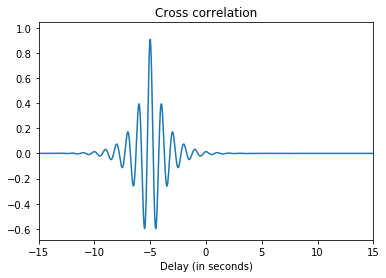

In [7]:
# plot cross-correlation
plt.figure(figsize=(6,4))
plt.plot(t_corr,G_xy)
plt.xlim((t_corr.min(),t_corr.max()))
plt.xlabel('Delay (in seconds)')
plt.ylim((1.15*G_xy.min(),1.15*G_xy.max()))
plt.title('Cross correlation')
plt.show()

OK, the cross-correlation has a very neat peak here, but how robust is this ?  
I mean, what if we **really** hide the signal in a buttload of noise ?

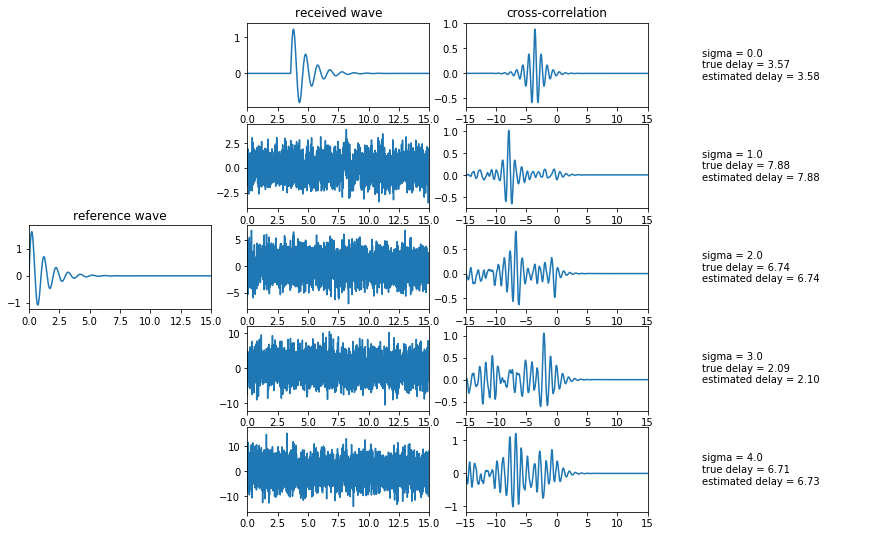

In [8]:
sigma = np.linspace(0,4,5)

plt.figure(figsize=(15,9))
plt.subplot(5,4,9)
plt.plot(t,x_ref)
plt.xlim((tmin,tmax))
plt.ylim((1.15*x_ref.min(),1.15*x_ref.max()))
plt.title('reference wave')

for ii,s in enumerate(sigma):
    (y_ii,delay_ii) = simulateEcho(t,A=0.75*A_ref,sigma=s)
    G_xy_ii = Te*sp.signal.correlate(x_ref,y_ii,method='direct')
    delay_est_ii = -t_corr[np.argmax(G_xy_ii)]
    
    plt.subplot(5,4,2+4*ii)
    if ii==0:
        plt.title('received wave')
    plt.plot(t,y_ii)
    plt.xlim((tmin,tmax))
    plt.ylim((1.15*y_ii.min(),1.15*y_ii.max()))
    
    plt.subplot(5,4,3+4*ii)
    if ii==0:
        plt.title('cross-correlation')
    plt.plot(t_corr,G_xy_ii)
    plt.xlim((t_corr.min(),t_corr.max()))
    plt.ylim((1.15*G_xy_ii.min(),1.15*G_xy_ii.max()))
    
    txt = 'sigma = %0.1f \ntrue delay = %1.2f \nestimated delay = %1.2f'%(s,delay_ii,delay_est_ii)
    plt.subplot(5,4,4+4*ii)
    plt.text(0.1,0.33,txt)
    plt.axis('off')

And what if we correlate the signal with a delayed version of...itself? 
Let us define $$\Gamma_{xx} (\tau) = \left\langle x(t),x(t-\tau)\right\rangle = \int_\mathbb{R} x(t) \overline{{x(t-\tau)}}dt$$ to be the **inter-correlation** of x.  

$\Gamma_{xx}(\tau)$ has several theoretical properties which are easy to check:
- if $x$ is a real signal, then $\Gamma_{xx}$ is an even function.
- $\Gamma_{xx}(0) = \| x \|^2 = \text{E}_x \equiv$ the signal energy
- $|\Gamma_{xx}(\tau)| \leq \Gamma_{xx}(0) \ \forall \tau \Rightarrow$ the autocorrelation is maximal in $0$

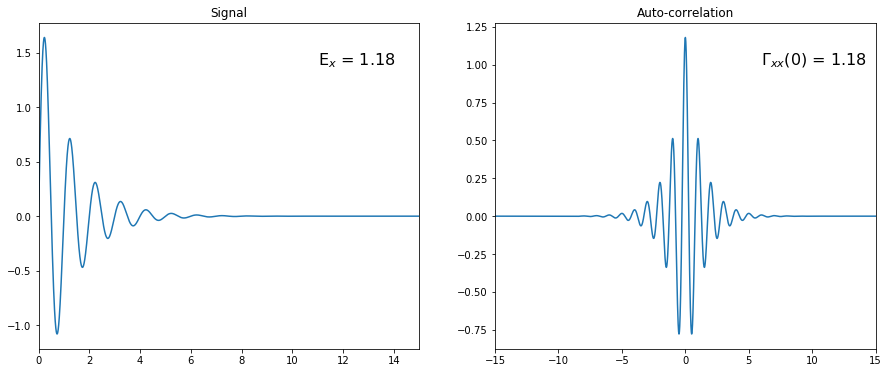

In [9]:
# Non-periodic functions, uncomment proper lines

# Rectangle function
# x = np.ones(t.size)*((t>=2)&(t<4))
# G_xx = Te*sp.signal.correlate(x,x, method='direct')

# Exponential function
# x = np.exp(-(t-1)/2)*(t>=1)
# G_xx = Te*sp.signal.correlate(x,x, method='direct')

# The previous gaussian modulated pulse...
A_ref = 2
t0 = 1.2
f0 = 1
x = A_ref*np.exp(-t/t0)*np.sin(2*pi*f0*t)
G_xx = Te*sp.signal.correlate(x,x, method='direct')

# Truncated sine
# Nperiod = 6
# x = np.sin(2*pi*t)*((t>=1)&(t<Nperiod+1))
# G_xx = Te*sp.signal.correlate(x,x, method='direct')

# Whatever the input signal
Ex = Te*(x**2).sum() # energy of signal
maxG_xx = G_xx.max() # maximum of correlation, should be equlat to the energy and reached for tau = 0

# ----------------------------------
# -------- plot that stuff ---------
# ----------------------------------
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(t,x)
plt.text(11,0.85*x.max(),r'E$_x$ = %1.2f'%Ex,fontsize=16)
plt.xlim((t.min(),t.max()))
plt.title('Signal')
plt.subplot(122)
plt.plot(t_corr,G_xx)
plt.text(6,0.85*maxG_xx,r'$\Gamma_{xx}(0)$ = %1.2f'%maxG_xx,fontsize=16)
plt.xlim((t_corr.min(),t_corr.max()))
plt.title('Auto-correlation')
plt.show()

Another property of the autocorrelation function is that it becomes periodic if the original signal also is. That should make a lot of sense, but it doesn't hurt to check it, right?

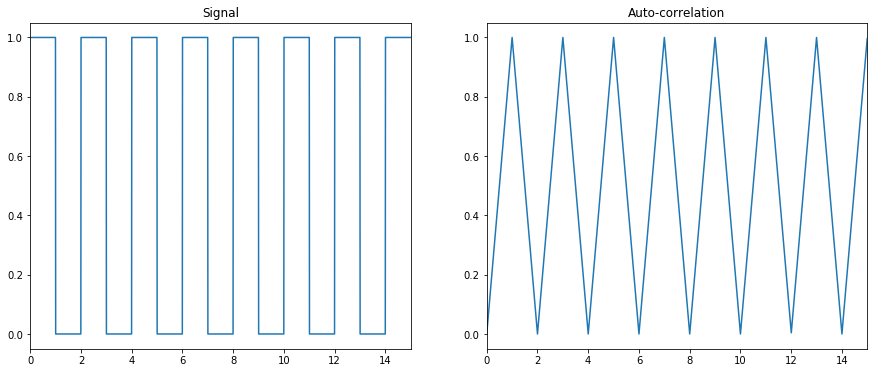

In [10]:
# Some periodic functions, uncomment proper lines

# Rectangle wave
x = (1+sp.signal.square(t*pi))/2
pattern = x[t<2]
G_xx = Te*sp.signal.correlate(x,pattern,method='direct',mode='same')

# Sinus wave
# x = np.sin(2*pi*t)
# pattern = x[t<1]
# G_xx = Te*sp.signal.correlate(x,pattern,method='direct',mode='same')

# ----------------------------------
# -------- plot that stuff ---------
# ----------------------------------
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(t,x)
plt.xlim((t.min(),t.max()))
plt.title('Signal')
plt.subplot(122)
plt.plot(t,G_xx)
plt.xlim((t.min(),t.max()))
plt.title('Auto-correlation')
plt.show()

And what about a correlation between a signal, and a noisy version of this signal? Let's see with a nice ECG example! 



<img src='https://openclipart.org/image/2400px/svg_to_png/279762/Cat-EKG.png', width="500">  



(OK, maybe not that one...)

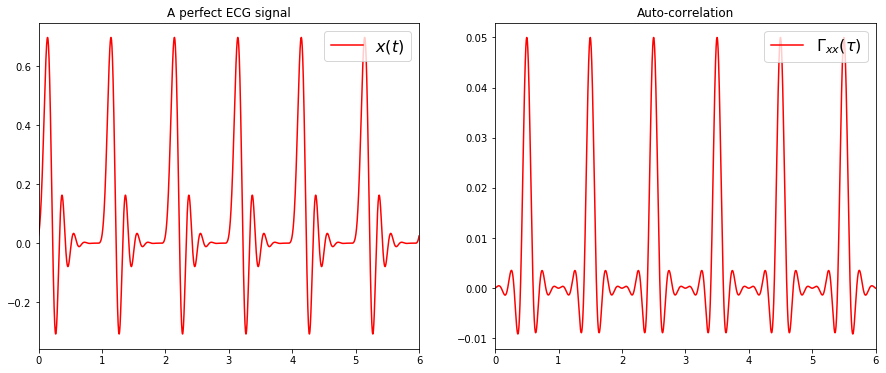

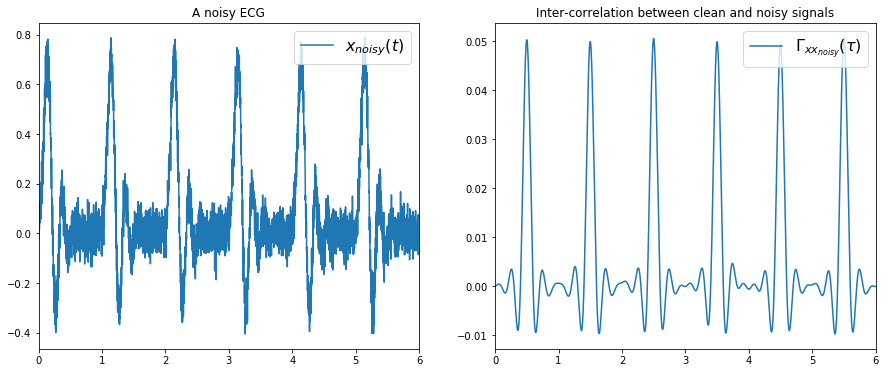

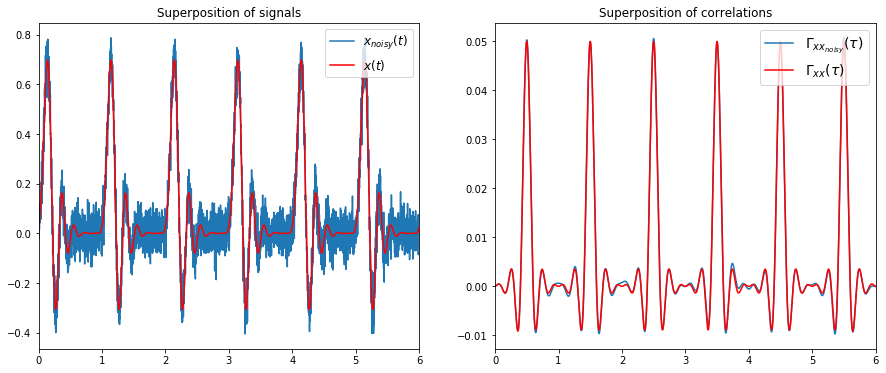

In [12]:
# Simulation of ECG
Nbeats = 6 # number of heart beats
ecg_clean, t_ecg = ECG.ECG_simul(Nbeats, t.size) # simulate the ECG wave
Tech_ecg = (t_ecg.max()-t_ecg.min())/t_ecg.size
ecg_pattern = ecg_clean[t_ecg<t_ecg.max()/Nbeats] # extract one pattern from the whole ECG signal
G_xx_ecg = Tech_ecg*sp.signal.correlate(ecg_clean,ecg_pattern, method='direct', mode='same') # compute autocorrelation

# Let's add some noise to this ECG
ecg_noisy = ecg_clean + np.random.normal(0, 0.05, ecg_clean.size)
G_xx_ecg_noisy = Tech_ecg*sp.signal.correlate(ecg_noisy,ecg_pattern, method='direct', mode='same') # autocorrelation


# ----------------------------------
# -------- plot that stuff ---------
# ----------------------------------
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(t_ecg,ecg_clean,'r',label=r'$x(t)$')
plt.xlim((t_ecg.min(),t_ecg.max()))
plt.title('A perfect ECG signal')
plt.legend(loc='upper right',fontsize=16)
plt.subplot(1,2,2)
plt.plot(t_ecg,G_xx_ecg,'r',label=r'$\Gamma_{xx}(\tau)$')
plt.xlim((t_ecg.min(),t_ecg.max()))
plt.title('Auto-correlation')
plt.legend(loc='upper right',fontsize=16)

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(t_ecg,ecg_noisy,label=r'$x_{noisy}(t)$')
plt.xlim((t_ecg.min(),t_ecg.max()))
plt.title('A noisy ECG')
plt.legend(loc='upper right',fontsize=16)
plt.subplot(122)
plt.plot(t_ecg,G_xx_ecg_noisy,label=r'$\Gamma_{xx_{noisy}}(\tau)$')
plt.xlim((t_ecg.min(),t_ecg.max()))
plt.title('Inter-correlation between clean and noisy signals')
plt.legend(loc='upper right',fontsize=16)

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(t_ecg,ecg_noisy,label=r'$x_{noisy}(t)$')
plt.plot(t_ecg,ecg_clean,'r',label=r'$x(t)$')
plt.xlim((t_ecg.min(),t_ecg.max()))
plt.title('Superposition of signals')
plt.legend(loc='upper right',fontsize=12)
plt.subplot(122)
plt.plot(t_ecg,G_xx_ecg_noisy,label=r'$\Gamma_{xx_{noisy}}(\tau)$')
plt.plot(t_ecg,G_xx_ecg,'r',label=r'$\Gamma_{xx}(\tau)$')
plt.xlim((t_ecg.min(),t_ecg.max()))
plt.title('Superposition of correlations')
plt.legend(loc='upper right',fontsize=14)
plt.show()

So, it really looks like $\Gamma_{xx} (\tau) \simeq \Gamma_{xx_{\text{noisy}}} (\tau)$. Why is that? Let's expand a little bit what $\Gamma_{xx_{\text{noisy}}}$ really is.  
The noisy signal $x_\text{noisy}$ was defined as $x + \eta_\sigma$, where $\eta_\sigma(t)$ stands for the noise at time $t$. It requires some bit more advanced signal processing notions to formally define what $\eta_\sigma$ is, but put simply, we could say that for every time $t$, $\eta_\sigma(t)$ is drawn from a Gaussian distribution with zero mean and variance $\sigma^2$, $\eta_\sigma(t) \sim \mathcal{N}(0,\sigma^2)$.  
By definition, $\Gamma_{xx_{\text{noisy}}} (\tau) = \langle x(t), x_\text{noisy}(t-\tau)\rangle = \langle x(t), x(t-\tau)+\eta_\sigma(t-\tau)\rangle = \langle x(t), x(t-\tau)\rangle + \langle x(t), \eta_\sigma(t-\tau)\rangle = \Gamma_{xx} (\tau) + \Gamma_{x\eta_\sigma} (\tau)$  
And one of the fundamental property of an independant additive noise (what $\eta_\sigma$ is in signal processing terms) is that it is uncorrelated to any signal, hence $\Gamma_{x\eta_\sigma} (\tau) = 0 \ \forall \tau$.  
So, theoretically, the intercorrelation of a signal with a noisy version of the signal should be equal to the autocorrelation of the signal with itself. Here, it is not stricly the case (although we are close to that) because the signal is (by essence) digital, and the computation of $\Gamma_{x\eta_\sigma}$ is done on a discrete and finite time vector.

### Convolution

The convolution product is the mathematical operation responsible for any linear time-invariant filtering, and it finds applications in numerous engineering/mathematical fields (not only signal processing).  

But a picture probably speaks better than words, so let's take a practical example.
At that time, you probably want to escape from this course. You have a plan: sending an "SOS" message (in morse) to your partners in crime outside of the room, to make them trigger the fire alarm. But we are evil, we installed a signal scrambler so that the signal received is totally blurred... Will they manage to understand your signal and free you?

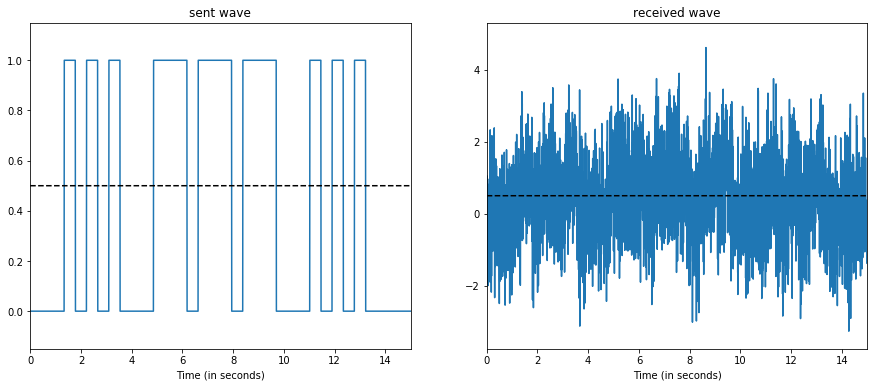

In [13]:
# Define the SOS sequence according to the principles of MORSE code
vecteur_morse = MASI.HEEEEEEELP(t,1)
x_refsquare = vecteur_morse[:len(t)]

# Add noise to the reference square signal
sig = 1
x_noisysquare = x_refsquare + sig*np.random.normal(size=t.shape)

# ----------------------------------
# -------- plot that stuff ---------
# ----------------------------------
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(t,x_refsquare)
plt.plot(t,0.5*np.ones(t.shape),'--k')
plt.xlim((t.min(),t.max()))
plt.xlabel('Time (in seconds)')
plt.ylim((-0.15,1.15))
plt.title('sent wave')
plt.subplot(122)
plt.plot(t,x_noisysquare)
plt.plot(t,0.5*np.ones(t.shape),'--k')
plt.xlim((t.min(),t.max()))
plt.xlabel('Time (in seconds)')
plt.ylim((1.15*x_noisysquare.min(),1.15*x_noisysquare.max()))
plt.title('received wave')
plt.show()

To decide whether the received signal value at a given time $t$ was initially a 0 or a 1, we can simply compare it with respect to the threshold value $\displaystyle\frac{1}{2}$.  
(eventhough it may seem dumb or straighforward, we could actually demonstrate that this is the __optimal__ strategy (_i.e._, any other strategy would yield more errors than this one) to recover the original signal value. This would require some more advanced statistical tools though, but you can trust my words ðŸ˜‰)

In [14]:
# Let's threshold and see how many errors we would do
nberrors = (x_refsquare != (x_noisysquare>0.5)).sum()
print("The value after thresholding is wrong %d times out of %d (%2.1f%% of error)."
      %(nberrors,x_refsquare.size,100*nberrors/x_refsquare.size))

The value after thresholding is wrong 1159 times out of 3750 (30.9% of error).


The simplest solution to mitigate this effect is to low-pass filter the received wave first. And that's where the convolution product comes in handy.

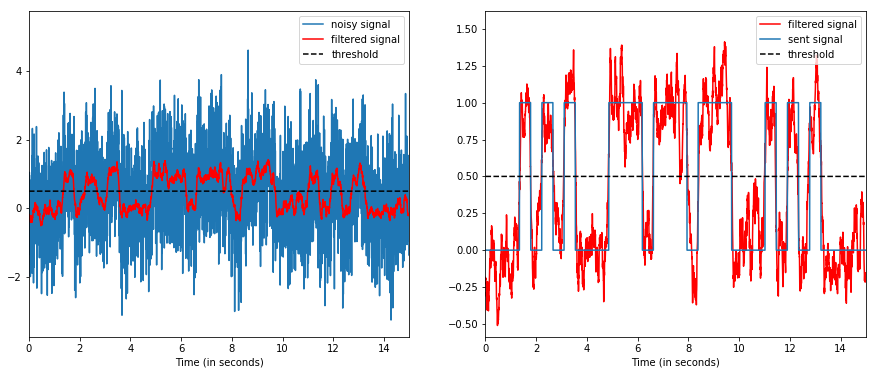

In [15]:
# Define low-pass filter
filtsize = 33
filt = np.ones(filtsize)/filtsize
# Convolve noisy signal with defined low-pass filter
x_filteredsquare = sp.signal.convolve(x_noisysquare,filt,mode='same',method='direct')
# ----------------------------------
# -------- plot that stuff ---------
# ----------------------------------
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(t,x_noisysquare,label='noisy signal')
plt.plot(t,x_filteredsquare,'r',label='filtered signal')
plt.plot(t,0.5*np.ones(t.shape),'--k',label='threshold')
plt.xlim((t.min(),t.max()))
plt.xlabel('Time (in seconds)')
plt.ylim((1.15*x_noisysquare.min(),1.25*x_noisysquare.max()))
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(t,x_filteredsquare,'r',label='filtered signal')
plt.plot(t,x_refsquare,label='sent signal')
plt.plot(t,0.5*np.ones(t.shape),'--k',label='threshold')
plt.xlim((t.min(),t.max()))
plt.xlabel('Time (in seconds)')
plt.ylim((1.15*x_filteredsquare.min(),1.15*x_filteredsquare.max()))
plt.legend(loc='upper right')
plt.show()

In [16]:
# Let's threshold again and see how many errors we would do, this time with the filtered signal
nberrors = (x_refsquare != (x_filteredsquare>0.5)).sum()
print("The value after thresholding is wrong %d times out of %d (%2.1f%% of error)."
      %(nberrors,x_refsquare.size,100*nberrors/x_refsquare.size))

The value after thresholding is wrong 111 times out of 3750 (3.0% of error).


And that sure looks better ! 

Unfortunately, your partners in crime haven't followed MASI and so, they don't know how to extract the information from the noisy signal and will never trigger the fire alarm... You're stuck here! **(evil laugh)**
<img src="https://media.giphy.com/media/YEe4Y10PuOTYI/giphy.gif">

Now, let's dig in the maths:  
Let us take $f, g \in \mathcal{L}^1(\mathbb{R})$, then the convolution product of $f$ and $g$ is defined as
$$(f\ast g)(t) = \int_{-\infty}^{+\infty} f(x)g(t-x)dx = \int_{-\infty}^{+\infty} g(x)f(t-x)dx$$

what is actually going on |
:---|---:
    |
<ol type="1"=><li> Express each function in terms of a dummy variable (here, $x$) <br style="line-height:8;"><br></li><li> Reflect one of the function: $g(x) \rightarrow g(-x)$ <br style="line-height:8;"><br></li><li> Shift $g(-x)$ to the left by an amount of $t$: $g(-x) \rightarrow g(t-x)$<br style="line-height:8;"><br></li><li> Slide $g(t-x)$ along the time axis ($t$ goes from $-\infty$ to $+\infty$).<br>If $f(x)$ and $g(t-x)$ intersect, compute the integral of their product <br> $\Rightarrow$ that is the value of $(f\ast g)(t)$ <br style="line-height:10;"><br></li></ol> | <img src="https://upload.wikimedia.org/wikipedia/commons/7/79/Convolution3.svg" width="500">

That might look scary in the first place, but this is nothing else than a moving average, where one function is "seen" through the other one.  

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a8/Splot1.gif" width=500>|<img src="https://upload.wikimedia.org/wikipedia/commons/7/7c/Splot2.gif" width=500>
---|---
|

Cherry on the cake, this example also illustrates the fact that the convolution operation is commutative.

We can also check that the convolution of a window function with itself is a triangle function whose support is twice as big as the one of the window function  
<img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif" width="500">

### Convolution vs correlation: a comparison

So, the integral definitions of the convolution product and the correlation operation really looks alike. And actually, those two operations are linked by the following formula: $$ \Gamma_{xy}(\tau) = \left(x \ast \overline{y^{-}}\right)(\tau) $$
where $y^{-}(t) = y(-t)$ (_i.e._, that is the flipped version of $y$) and the uppermost bar stands for the complex conjugate.  
So, if $y$ is a real signal, $$ \Gamma_{xy}(\tau) = \left(x \ast y^{-}\right)(\tau) $$
in which case the intercorrelation between $x$ and $y$ is equivalent to the convolution of $x$ and the flipped version of $y$.  
Well, that looks like some property that should be easy to empirically check.

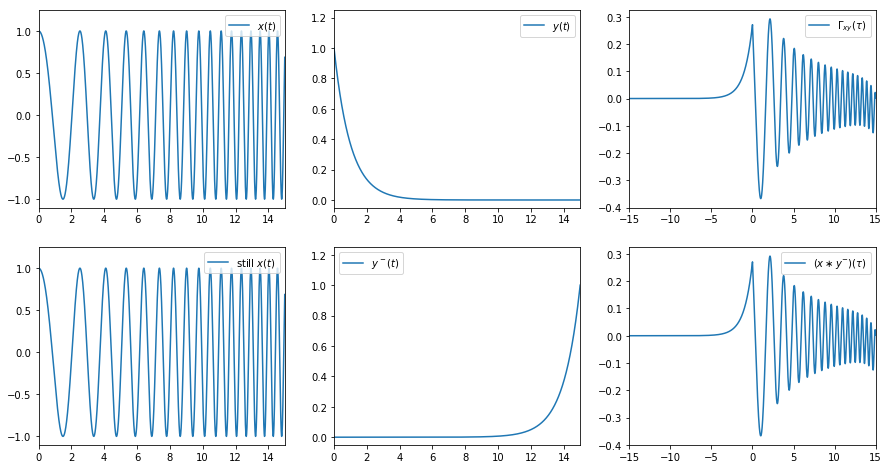

In [17]:
# Let's define two signals
x = sp.signal.chirp(t, 0.25, t.max(), 2)
y = np.exp(-t)
y_minus = np.flip(y, axis=0)

# Now let's compute the classical intercorrelation between x and y
G_xy = Te*sp.signal.correlate(x,y,method='direct')
# Beside, let's compute the convolution between x and the flipped version of y
conv_xy_minus = Te*sp.signal.convolve(x,y_minus,method='direct')


plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
plt.plot(t,x,label=r'$x(t)$')
plt.xlim(t.min(),t.max())
plt.ylim(ymax=1.25)
plt.legend(loc='upper right')
plt.subplot(2,3,2)
plt.plot(t,y,label=r'$y(t)$')
plt.xlim(t.min(),t.max())
plt.ylim(ymax=1.25)
plt.legend(loc='upper right')
plt.subplot(2,3,3)
plt.plot(t_corr,G_xy,label=r'$\Gamma_{xy}(\tau)$')
plt.xlim(t_corr.min(),t_corr.max())
plt.legend(loc='upper right')

plt.subplot(2,3,4)
plt.plot(t,x,label=r'still $x(t)$')
plt.xlim(t.min(),t.max())
plt.ylim(ymax=1.25)
plt.legend(loc='upper right')
plt.subplot(2,3,5)
plt.plot(t,y_minus,label=r'$y^-(t)$')
plt.xlim(t.min(),t.max())
plt.ylim(ymax=1.25)
plt.legend(loc='upper left')
plt.subplot(2,3,6)
plt.plot(t_corr,conv_xy_minus,label=r'$\left(x\ast y^{-}\right)(\tau)$')
plt.xlim(t_corr.min(),t_corr.max())
plt.legend(loc='upper right')
plt.show()

OK, they look alike, all good. Let's plot the difference just to be sure.

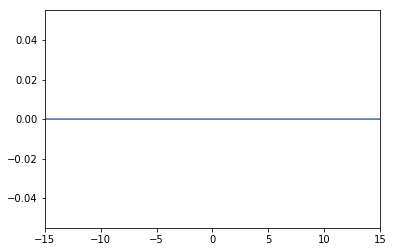

In [18]:
plt.figure(figsize=(6,4))
plt.plot(t_corr,G_xy-conv_xy_minus)
plt.xlim(t_corr.min(),t_corr.max())
plt.show()

That couldn't be clearer...

And to finish, another short video to illustrate this moving average principle that is lying behind the convolution, and hence the correlation...

<video controls src="corr.mp4" />